# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from numpy.random import RandomState

In [2]:
RANDOM_STATE = RandomState(12345) 

In [3]:
if os.path.exists('autos.csv'):
    data = pd.read_csv('autos.csv')
elif os.path.exists('/datasets/autos.csv'):
    data = pd.read_csv('/datasets/autos.csv')
else:
    print('Something is wrong')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В первую очередь, можно заметить, что в данных присутствуют неинфоративные столбцы: DateCrawled, DateCreated, LastSeen и PostalCode. 

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

### Проверим используемые типы данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


### Обработаем пропуски и дубликаты

In [7]:
data.loc[data.duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures
1396,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,0
3025,2800,wagon,2005,NaN,0,touran,150000,11,gasoline,volkswagen,no,0
3458,300,small,2000,manual,54,corsa,150000,0,petrol,opel,NaN,0
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,0
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354336,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,0
354337,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,NaN,0
354352,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no,0
354355,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no,0


Удалим полностью совпадающие строки

In [8]:
data=data.drop_duplicates().reset_index(drop=True)

In [9]:
data.loc[data.drop('Price', axis=1).duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures
1281,3750,sedan,2003,manual,105,golf,150000,12,gasoline,volkswagen,no,0
1380,9600,sedan,2007,manual,177,1er,150000,8,gasoline,bmw,no,0
1396,4199,wagon,2001,manual,131,passat,150000,12,gasoline,volkswagen,no,0
1730,1500,small,1999,manual,60,polo,150000,3,petrol,volkswagen,no,0
1803,2000,bus,2002,manual,116,sharan,150000,10,gasoline,volkswagen,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
326809,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,0
326810,1400,sedan,2001,manual,125,astra,150000,2,petrol,opel,no,0
326816,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,0
326822,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,0


Также если убрать искомый признак, то найдутся еще дубликаты строк. Удалим такие дубликаты и изменим колонку price на медианное значение от каждой стоимость повторяющихся строк.

In [10]:
data.loc[data.drop('Price', axis=1).duplicated(keep=False)].sort_values(by=data.drop('Price', axis=1).columns.values.tolist(), axis=0)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures
36767,17950,bus,1976,manual,50,other,100000,0,petrol,volkswagen,no,0
123189,13900,bus,1976,manual,50,other,100000,0,petrol,volkswagen,no,0
82627,7900,bus,1982,manual,65,sprinter,70000,10,gasoline,mercedes_benz,no,0
136900,5500,bus,1982,manual,65,sprinter,70000,10,gasoline,mercedes_benz,no,0
194278,4999,bus,1985,manual,50,transporter,150000,12,gasoline,volkswagen,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
160753,1000,NaN,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,0
190680,850,NaN,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,0
15063,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,0
143345,400,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,0


In [11]:
data = data.groupby(data.drop('Price', axis=1).columns.values.tolist(), as_index=False, dropna=False).agg(Price = ('Price','mean')).reset_index(drop=True)

In [12]:
data

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,Price
0,bus,1910,manual,0,NaN,150000,12,gasoline,sonstige_autos,NaN,0,1.000000
1,bus,1910,manual,999,espace,150000,0,NaN,renault,NaN,0,1500.000000
2,bus,1910,NaN,0,transporter,5000,0,NaN,volkswagen,NaN,0,0.000000
3,bus,1950,NaN,0,transporter,5000,11,petrol,volkswagen,NaN,0,0.000000
4,bus,1953,NaN,0,NaN,150000,1,petrol,sonstige_autos,NaN,0,6666.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
258685,NaN,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,0,616.666667
258686,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,0,183.333333
258687,NaN,9999,NaN,0,NaN,10000,0,NaN,volkswagen,NaN,0,0.000000
258688,NaN,9999,NaN,0,NaN,10000,7,NaN,mazda,NaN,0,0.000000


Проверим на наличие **пропуков**

In [13]:
passes = data.isna().sum()
display(passes[passes!=0])
#passes_train = passes[passes!=0].index

VehicleType    30261
Gearbox        14990
Model          17013
FuelType       27821
Repaired       57240
dtype: int64

Посмотрим, сколько пропусков в соотношении ко всем значениям

In [14]:
passes[passes!=0]/len(data)

VehicleType    0.116978
Gearbox        0.057946
Model          0.065766
FuelType       0.107546
Repaired       0.221269
dtype: float64

Рассмотрим каждый признак отдельно

In [15]:
data['VehicleType'].value_counts()

sedan          64066
small          56095
wagon          45026
bus            21871
convertible    15676
coupe          12977
suv             9616
other           3102
Name: VehicleType, dtype: int64

Змаетим, что в данных присутсвует значение 'other', по факту он и может стать заменой пропуска.

In [16]:
data['VehicleType'] = data['VehicleType'].fillna('other')

Так как для Gearbox нельзя подобрать соотвествуйщей замены, то удалим эти пропуски, так как они не должны сильно изменить распределение, учитывая, что занимают около 5%-6% от всех данных

In [17]:
data['Gearbox'].value_counts(dropna=False)

manual    192780
auto       50920
NaN        14990
Name: Gearbox, dtype: int64

In [18]:
data = data.dropna(subset=['Gearbox']).reset_index(drop=True)

In [19]:
data['Model'].value_counts(dropna=False)

other                 20376
golf                  16741
NaN                   14309
3er                   12157
polo                   7465
                      ...  
i3                        7
rangerover                4
serie_3                   3
range_rover_evoque        1
serie_1                   1
Name: Model, Length: 251, dtype: int64

В столбце Model также присутсвует значение 'other', замним пропуски на него.

In [20]:
data['Model'] = data['Model'].fillna('other')

In [21]:
data['FuelType'].value_counts(dropna=False)

petrol      151354
gasoline     64989
NaN          21910
lpg           4527
cng            481
hybrid         218
other          144
electric        77
Name: FuelType, dtype: int64

Аналогично с FuelType

In [22]:
data['FuelType'] = data['FuelType'].fillna('other')

In [23]:
data['Repaired'].value_counts(dropna=False)

no     165576
NaN     48395
yes     29729
Name: Repaired, dtype: int64

In [24]:
data['Repaired'] = data['Repaired'].fillna('unknown')

К данному столбцу нельзя подобрать соотвествующую замену, поэтому оставим пропуски, так как процент пропусков в данном случае уже составляет около 20 процентов и в случае удаления может повлиять на распределение. Но заменим значение None на 'unknown' для успешного дальнейшего закодирования

In [25]:
passes = data.isna().sum()
passes[passes!=0]/len(data)

Series([], dtype: float64)

### Приведем название столбцов к нижнему регистру

In [26]:
data.columns=data.columns.str.lower()

In [27]:
list_columns = data.columns.tolist()

In [28]:
list_columns[0]='vehicle_type'
list_columns[1]='registration_year'
list_columns[6]='registration_month'
list_columns[7]='fuel_type'
list_columns[10]='number_of_pictures'
data.columns = list_columns

In [29]:
data.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired',
       'number_of_pictures', 'price'],
      dtype='object')

In [30]:
data['number_of_pictures'].value_counts(dropna=False)

0    243700
Name: number_of_pictures, dtype: int64

Столбец numberofpictures состоит только из нулей - удалим этот столбец, он не несет никакой информации

In [31]:
data.drop(columns=['number_of_pictures'], axis= 1 , inplace= True )

### Поиск аномалий

Рассмотрим столбец registration_year

<AxesSubplot:xlabel='registration_year'>

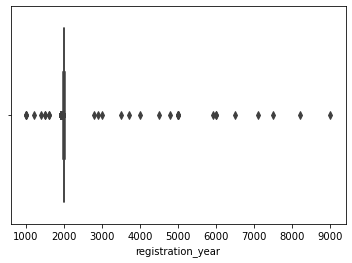

In [32]:
sns.boxplot(x=data['registration_year'])

Удалим все значения, которые превышают значения "усов"

In [33]:
def delete_anomal(data_new, column_name, delete=False):  
    q3 = data_new[column_name].quantile(0.75)
    q1 = data_new[column_name].quantile(0.25)
    IQR = q3 - q1
    print('Ограничение снизу значением:',q1 - 1.5*IQR)
    print('Ограничение сверху значением:',q3 + 1.5*IQR)
#     print(data.loc[(data[column_name] <= q1 - 1.5*IQR) | (data[column_name] >= q3 + 1.5*IQR)][column_name].count())
    print(data[column_name].count())
    if delete == True:
        return data_new.loc[(data_new[column_name] >= q1 - 1.5*IQR) & (data_new[column_name] <= q3 + 1.5*IQR)].reset_index(drop=True)
    else:
        print('Доля: ', data_new.loc[(data_new[column_name] <= q1 - 1.5*IQR) | (data_new[column_name] >= q3 + 1.5*IQR)][column_name].count() / data_new[column_name].count())
        return data_new

Удалим все строки, у которых год регистрации больше 2016

In [34]:
data.loc[data['registration_year']>2016]['registration_year'].count()

10832

In [35]:
data=data.loc[data['registration_year']<=2016].reset_index(drop=True)

Рассмотрим столбец power

<AxesSubplot:xlabel='power'>

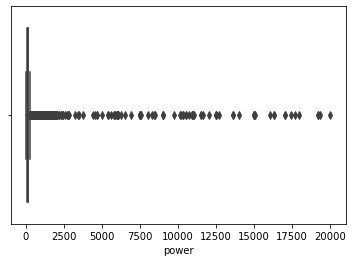

In [36]:
sns.boxplot(x=data['power'])

In [37]:
data = delete_anomal(data, 'power')

Ограничение снизу значением: -28.5
Ограничение сверху значением: 247.5
232868
Доля:  0.027977223147877768


Выбросы составляют около 2.5%, поэтому можно удалить их.

In [38]:
data = delete_anomal(data, 'power', delete=True)

Ограничение снизу значением: -28.5
Ограничение сверху значением: 247.5
232868


<AxesSubplot:xlabel='power'>

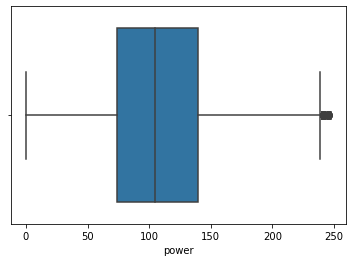

In [39]:
#plt.xlim(0, 1000)
sns.boxplot(x=data['power'])

Рассмотрим столбец kilometer

In [40]:
data = delete_anomal(data, 'kilometer')

Ограничение снизу значением: 25000.0
Ограничение сверху значением: 225000.0
226353
Доля:  0.0327276422225462


<AxesSubplot:xlabel='kilometer'>

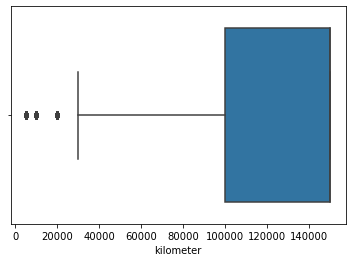

In [41]:

sns.boxplot(x=data['kilometer'])

Пробег машины может быть близок к нулю, если она новая, поэтому не будем удалять данные выбросы.(еще потому, что они составляют 14% от всех данных - это много)

Рассмотрим столбец registration_month

In [42]:
data['registration_month'].value_counts()

3     21866
6     20330
0     19781
4     19211
5     19006
7     17966
10    16803
9     15750
12    15647
11    15580
1     15243
8     15039
2     14131
Name: registration_month, dtype: int64

Удалим столбец registration_month


In [43]:
data=data.drop('registration_month', axis=1)

Рассмотрим целевой столбец Price

In [44]:
data = delete_anomal(data, 'price')

Ограничение снизу значением: -6972.5
Ограничение сверху значением: 14583.5
226353
Доля:  0.05306755377662324


<AxesSubplot:xlabel='price'>

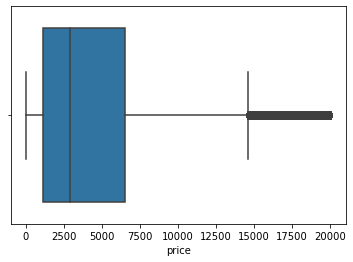

In [45]:
sns.boxplot(x=data['price'])

Высокое значение цены вполне возможно, поэтому оставим эти значения без изменений.

### Проверим данные на корреляцию

<AxesSubplot:>

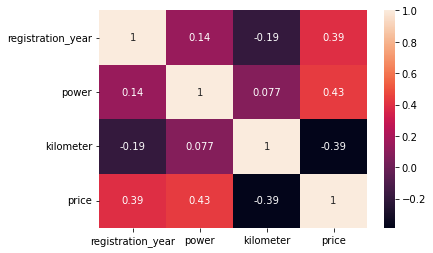

In [46]:
sns.heatmap(data.corr(), annot = True)

Из матрицы корреляции видно, что на целевой признак сельнее всего влияет значение года регистрации машины и ее мощность.

### Вывод

Из проделанной работе можно сделать следующий вывод:
1. В данных содержались пропуски, в местах, где существовала разумная замена, она была проведена, в других случаях пропуски оставили без изменения.
2. Были убраны следующий столбцы в связи с их неинфомативностью: number_of_pictures, DateCrawled, DateCreated, LastSeen и PostalCode.
3. В некоторых данных присутсвовали выбросы. Если процент выбросов был не велик, то они удалялись, в ином случае, когда значения выбросов возможны в действительности, их не изменяли.
4. При потсроении матрицы корреляции было выявлено, что у признаков нет взаимной сильной корреляции. Также были выделены два признака, которые сильнее всего влияют на целевой признак.

## Обучение моделей

Функция, которая разделяет данные на тестовые, валидационные и тренировочные

In [47]:
def get_features_target(dataset):
    features_train, features_train_valid, target_train, target_train_valid = train_test_split(
            dataset.drop('price', axis = 1), dataset['price'], test_size=0.3, random_state=RANDOM_STATE) 
    features_test, features_valid, target_test, target_valid = train_test_split(
            features_train_valid, target_train_valid, test_size=0.5, random_state=RANDOM_STATE)
    return features_train, features_test, features_valid, target_train, target_test, target_valid

Функция, которая проводит необходимые преобразования наоборов данных для каждой модели.

In [48]:
def get_ft_model(dataset, name_model):
    if name_model == 'RandomForestRegressor' or name_model == 'DecisionTreeRegressor':
        categories=['vehicle_type','gearbox' ,'model', 'fuel_type', 'brand', 'repaired']
        buf_data = dataset.copy()
        features_train, features_test, features_valid, target_train, target_test, target_valid = get_features_target(buf_data)
        categor_columns=categories
        oe = OrdinalEncoder()
        oe.fit(features_train[categor_columns])
        buf_data[categor_columns] = oe.transform(buf_data[categor_columns])
    if name_model == 'LightGBM':
        features_train, features_test, features_valid, target_train, target_test, target_valid = get_features_target(dataset)
        features = object_to_category([features_train, features_valid, features_test])
        return features[0], target_train, features[1], target_valid, features[2], target_test
    elif name_model == 'RandomForestRegressor':

#         ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
#         drop_enc = ohe.fit(features_train[categor_columns])
#         data_ohe = ohe.transform(data[categor_columns]).toarray()
#         ohe_df = pd.DataFrame(data_ohe, columns=ohe.get_feature_names_out(categor_columns))
#         data_rfr = pd.concat([dataset, ohe_df], axis=1).drop(categor_columns, axis=1)
        features_train, features_test, features_valid, target_train, target_test, target_valid = get_features_target(buf_data)
        return features_train, target_train, features_valid, target_valid, features_test, target_test
    elif name_model == 'DecisionTreeRegressor':
        features_train, features_test, features_valid, target_train, target_test, target_valid = get_features_target(buf_data)
        return features_train, target_train, features_valid, target_valid, features_test, target_test
    elif name_model == 'CatBoostRegressor':
        features_train, features_test, features_valid, target_train, target_test, target_valid = get_features_target(dataset)
        return features_train, target_train, features_valid, target_valid, features_test, target_test
    else:
        print('Неправильно введеное имя модели')
    

Функция перевода категориальных переменных типа object к типу category, так как модель LightGBM принимает категориальные переменные тоолько типа category.

In [49]:
def object_to_category(features_to_change): 
    for elem in features_to_change:
        for c in ['vehicle_type','gearbox' ,'model', 'fuel_type', 'brand', 'repaired']:
            elem[c] = elem[c].astype('category')
    return features_to_change

Функция создания модели и подброра гиперпараметров

In [50]:
def model_param(name_model, list_iter, f_train, t_train, f_valid, t_valid):
    best_rmse = 0
    best_tree_number = None
    best_depth = None
    best_learning_rate = None
    best_rmse = None
    for tree_number in list_iter.get('trees_count', [None]):
        for depth in list_iter.get('depth_count', [None]):
            for rate in list_iter.get('learning_rate', [None]):
                
                if name_model == 'LightGBM':
                    print('LightGBM')
                    model = LGBMRegressor(n_jobs=-1, n_estimators=tree_number, learning_rate=rate, random_state=RANDOM_STATE,
                                          num_leaves = 2**depth)
                    %time model.fit(f_train, t_train, eval_set=[(f_valid, t_valid)], eval_metric=["rmse"],categorical_feature=['vehicle_type','gearbox' ,'model', 'fuel_type', 'brand', 'repaired'])
                    
                    
                elif name_model == 'RandomForestRegressor':
                    model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=tree_number, max_depth = depth, n_jobs=-1)
                    %time model.fit(f_train, t_train)
                
                elif name_model == 'CatBoostRegressor':
                    model = CatBoostRegressor(n_estimators=tree_number, learning_rate=rate, random_state=12345, depth=depth,loss_function='RMSE')
                    %time model.fit(f_train, t_train,cat_features = list(data.select_dtypes('object', 'category').columns), verbose=10)
                
                elif name_model == 'DecisionTreeRegressor':
                    model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
                    %time model.fit(f_train, t_train)
                    
                else:
                    return 'Неправильно введеное имя модели'
                predictions = %time model.predict(f_valid)
                
                result_rmse = mean_squared_error(t_valid, predictions)**0.5
                
                if (tree_number == list_iter.get('trees_count', [None]) and depth == list_iter['depth_count'][0] and rate ==  list_iter.get('learning_rate', [None])) or (tree_number == list_iter.get('trees_count', [None]) and depth == list_iter['depth_count'][0])or (depth == list_iter['depth_count'][0]):
                        best_rmse = result_rmse
                
                print('rmse:', result_rmse,'',"n_estimators =", tree_number,'depth',depth,'learning_rate',rate)  
                print('--------------------------------')
                if result_rmse <= best_rmse:
                    #best_model = model
                    best_rmse = result_rmse
                    best_tree_number = tree_number
                    best_depth = depth
                    best_learning_rate = rate
    print("------------------Итог------------------")
    print("Лучшая модель по rmse:", best_rmse, "n_estimators =", best_tree_number,'learning_rate',best_learning_rate,'depth',best_depth)
    return [best_rmse, best_tree_number,best_learning_rate,best_depth]
    

     

Первой рассмотренной моделью будет LightGBM. Она работает с категориальными признаками напрямую, поэтому мы не будем их кодировать.

In [51]:
dict_model = {}

In [52]:
features_train, target_train, features_valid, target_valid, features_test, target_test = get_ft_model(data, 'LightGBM')

In [53]:
dict_model['LightGBM'] = model_param('LightGBM', {'trees_count':[80, 100, 200,300, 400, 500], 'depth_count':[1, 2, 3, 4],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}, features_train, target_train, features_valid, target_valid)

LightGBM
[1]	valid_0's rmse: 4563.23	valid_0's l2: 2.0823e+07
[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07


C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[20]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[21]	valid_0's rmse: 4559.83	valid_0's l2: 2.0792e+07
[22]	valid_0's rmse: 4559.66	valid_0's l2: 2.07905e+07
[23]	valid_0's rmse: 4559.49	valid_0's l2: 2.0789e+07
[24]	valid_0's rmse: 4559.32	valid_0's l2: 2.07874e+07
[25]	valid_0's rmse: 4559.15	valid_0's l2: 2.07859e+07
[26]	valid_0's rmse: 4558.98	valid_0's l2: 2.07843e+07
[27]	valid_0's rmse: 4558.81	valid_0's l2: 2.07828e+07
[28]	valid_0's rmse: 4558.64	valid_0's l2: 2.07812e+07
[29]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[30]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[31]	valid_0's rmse: 4558.14	valid_0's l2: 2.07766e+07
[32]	valid_0's rmse: 4557.97	valid_0's l2: 2.07751e+07
[33]	valid_0's rmse: 4557.8	valid_0's l2: 2.07735e+07
[34]	valid_0's rmse: 4557.63	valid_0's l2: 2.0772e+07
[35]	valid_0's rmse: 4557.46	valid_0's l2: 2.07704e+07
[36]	valid_0's rms

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4398.72	valid_0's l2: 1.93487e+07
[2]	valid_0's rmse: 4259.86	valid_0's l2: 1.81464e+07
[3]	valid_0's rmse: 4141.37	valid_0's l2: 1.7151e+07
[4]	valid_0's rmse: 4042.22	valid_0's l2: 1.63396e+07
[5]	valid_0's rmse: 3955.95	valid_0's l2: 1.56495e+07
[6]	valid_0's rmse: 3884	valid_0's l2: 1.50855e+07
[7]	valid_0's rmse: 3812.88	valid_0's l2: 1.4538e+07
[8]	valid_0's rmse: 3749.58	valid_0's l2: 1.40593e+07
[9]	valid_0's rmse: 3691.44	valid_0's l2: 1.36267e+07
[10]	valid_0's rmse: 3638.41	valid_0's l2: 1.3238e+07
[11]	valid_0's rmse: 3589.12	valid_0's l2: 1.28817e+07
[12]	valid_0's rmse: 3544.11	valid_0's l2: 1.25607e+07
[13]	valid_0's rmse: 3501.37	valid_0's l2: 1.22596e+07
[14]	valid_0's rmse: 3463.71	valid_0's l2: 1.19973e+07
[15]	valid_0's rmse: 3426.06	valid_0's l2: 1.17379e+07
[16]	valid_0's rmse: 3388.96	valid_0's l2: 1.14851e+07
[17]	valid_0's rmse: 3355.24	valid_0's l2: 1.12577e+07
[18]	valid_0's rmse: 3323.27	valid_0's l2: 1.10441e+07
[19]	valid_0's rmse: 3294

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3607.37	valid_0's l2: 1.30131e+07
[2]	valid_0's rmse: 3294.11	valid_0's l2: 1.08512e+07
[3]	valid_0's rmse: 3153.23	valid_0's l2: 9.94284e+06
[4]	valid_0's rmse: 3003.14	valid_0's l2: 9.01885e+06
[5]	valid_0's rmse: 2887.91	valid_0's l2: 8.34002e+06
[6]	valid_0's rmse: 2829.01	valid_0's l2: 8.00332e+06
[7]	valid_0's rmse: 2777.13	valid_0's l2: 7.71247e+06
[8]	valid_0's rmse: 2687.35	valid_0's l2: 7.22186e+06
[9]	valid_0's rmse: 2644.32	valid_0's l2: 6.99244e+06
[10]	valid_0's rmse: 2611.52	valid_0's l2: 6.82002e+06
[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.17	valid_0's l2: 2.08225e+07
[2]	valid_0's rmse: 4562.94	valid_0's l2: 2.08204e+07
[3]	valid_0's rmse: 4562.7	valid_0's l2: 2.08183e+07
[4]	valid_0's rmse: 4562.47	valid_0's l2: 2.08162e+07
[5]	valid_0's rmse: 4562.24	valid_0's l2: 2.08141e+07
[6]	valid_0's rmse: 4562.01	valid_0's l2: 2.0812e+07
[7]	valid_0's rmse: 4561.78	valid_0's l2: 2.08099e+07
[8]	valid_0's rmse: 4561.55	valid_0's l2: 2.08077e+07
[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4540.36	valid_0's l2: 2.06149e+07
[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4338.44	valid_0's l2: 1.88221e+07
[2]	valid_0's rmse: 4139.33	valid_0's l2: 1.7134e+07
[3]	valid_0's rmse: 3970.1	valid_0's l2: 1.57617e+07
[4]	valid_0's rmse: 3815.08	valid_0's l2: 1.45548e+07
[5]	valid_0's rmse: 3676.28	valid_0's l2: 1.3515e+07
[6]	valid_0's rmse: 3543.15	valid_0's l2: 1.25539e+07
[7]	valid_0's rmse: 3430.65	valid_0's l2: 1.17693e+07
[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.1

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.12	valid_0's l2: 2.08221e+07
[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[2]	valid_0's rmse: 4557.93	valid_0's l2: 2.07747e+07
[3]	valid_0's rmse: 4555.2	valid_0's l2: 2.07498e+07
[4]	valid_0's rmse: 4552.47	valid_0's l2: 2.0725e+07
[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 451

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4536.07	valid_0's l2: 2.05759e+07
[2]	valid_0's rmse: 4509.12	valid_0's l2: 2.03322e+07
[3]	valid_0's rmse: 4482.39	valid_0's l2: 2.00919e+07
[4]	valid_0's rmse: 4456.04	valid_0's l2: 1.98563e+07
[5]	valid_0's rmse: 4429.59	valid_0's l2: 1.96213e+07
[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[3]	valid_0's rmse: 3838.78	valid_0's l2: 1.47363e+07
[4]	valid_0's rmse: 3656.33	valid_0's l2: 1.33687e+07
[5]	valid_0's rmse: 3489.54	valid_0's l2: 1.21769e+07
[6]	valid_0's rmse: 3337.28	valid_0's l2: 1.11374e+07
[7]	valid_0's rmse: 3196.5	valid_0's l2: 1.02176e+07
[8]	valid_0's rmse: 3078.59	valid_0's l2: 9.47769e+06
[9]	valid_0's rmse: 2971.05	valid_0's l2: 8.82711e+06
[10]	valid_0's rmse: 2876.85	valid_0's l2: 8.27625e+06
[11]	valid_0's rmse: 2788.93	valid_0's l2: 7.77815e+06
[12]	valid_0's rmse: 2705.47	valid_0's l2: 7.31957e+06
[13]	valid_0's rmse: 2631.15	valid_0's l2: 6.92293e+06
[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	valid_0's l2: 6.00348e+06
[17]	valid_0's rmse: 2398.55	valid_0's l2: 5.75304e+06
[18]	valid_0's rmse: 2352.67	valid_0's l2: 5.53508e+06
[19]	valid_0's rmse: 2308.11	valid_0's l2: 5.32739e+06
[20]	valid_0's rmse: 2270.36	valid_0's l2: 5.15451e+06
[21]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 2581.39	valid_0's l2: 6.66355e+06
[3]	valid_0's rmse: 2440.73	valid_0's l2: 5.95718e+06
[4]	valid_0's rmse: 2305.42	valid_0's l2: 5.31496e+06
[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 1929.19	valid_0's l2: 3.72179e+06
[20]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.08	valid_0's l2: 2.08217e+07
[2]	valid_0's rmse: 4562.77	valid_0's l2: 2.08189e+07
[3]	valid_0's rmse: 4562.46	valid_0's l2: 2.0816e+07
[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[3]	valid_0's rmse: 4554.03	valid_0's l2: 2.07392e+07
[4]	valid_0's rmse: 4550.92	valid_0's l2: 2.07108e+07
[5]	valid_0's rmse: 4547.81	valid_0's l2: 2.06825e+07
[6]	valid_0's rmse: 4544.7	valid_0's l2: 2.06543e+07
[7]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[8]	valid_0's rmse: 4538.5	valid_0's l2: 2.0598e+07
[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	valid_0's l2: 2.02923e+07
[20]	valid_0's rmse: 4501.65

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4532.18	valid_0's l2: 2.05406e+07
[2]	valid_0's rmse: 4501.37	valid_0's l2: 2.02623e+07
[3]	valid_0's rmse: 4470.97	valid_0's l2: 1.99895e+07
[4]	valid_0's rmse: 4440.97	valid_0's l2: 1.97222e+07
[5]	valid_0's rmse: 4411.31	valid_0's l2: 1.94596e+07
[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4256	valid_0's l2: 1.81135e+07
[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 212

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 2330.72	valid_0's l2: 5.43226e+06
[3]	valid_0's rmse: 2219.28	valid_0's l2: 4.92522e+06
[4]	valid_0's rmse: 2166.77	valid_0's l2: 4.69489e+06
[5]	valid_0's rmse: 2107.97	valid_0's l2: 4.44353e+06
[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 1879.7	valid_0's l2: 3.53325e+06
[20]	valid_0's rmse: 18

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.23	valid_0's l2: 2.0823e+07
[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07
[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4398.72	valid_0's l2: 1.93487e+07
[2]	valid_0's rmse: 4259.86	valid_0's l2: 1.81464e+07
[3]	valid_0's rmse: 4141.37	valid_0's l2: 1.7151e+07
[4]	valid_0's rmse: 4042.22	valid_0's l2: 1.63396e+07
[5]	valid_0's rmse: 3955.95	valid_0's l2: 1.56495e+07
[6]	valid_0's rmse: 3884	valid_0's l2: 1.50855e+07
[7]	valid_0's rmse: 3812.88	valid_0's l2: 1.4538e+07
[8]	valid_0's rmse: 3749.58	valid_0's l2: 1.40593e+07
[9]	valid_0's rmse: 3691.44	valid_0's l2: 1.36267e+07
[10]	valid_0's rmse: 3638.41	valid_0's l2: 1.3238e+07
[11]	valid_0's rmse: 3589.12	valid_0's l2: 1.28817e+07
[12]	valid_0's rmse: 3544.11	valid_0's l2: 1.25607e+07
[13]	valid_0's rmse: 3501.37	valid_0's l2: 1.22596e+07
[14]	valid_0's rmse: 3463.71	valid_0's l2: 1.19973e+07
[15]	valid_0's rmse: 3426.06	valid_0's l2: 1.17379e+07
[16]	valid_0's rmse: 3388.96	valid_0's l2: 1.14851e+07
[17]	valid_0's rmse: 3355.24	valid_0's l2: 1.12577e+07
[18]	valid_0's rmse: 3323.27	valid_0's l2: 1.10441e+07
[19]	valid_0's rmse: 3294

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse: 2359.83	valid_0's l2: 5.56878e+06
[20]	valid_0's rmse: 2345.61	valid_0's l2: 5.5019e+06
[21]	valid_0's rmse: 2331.74	valid_0's l2: 5.43702e+06
[22]	valid_0's rmse: 2314.53	valid_0's l2: 5.35706e+06
[23]	valid_0's rmse: 2304.9	valid_0's l2: 5.31258e+06
[24]	valid_0's rmse: 2291.78	valid_0's l2: 5.25224e+06
[25]	valid_0's rmse: 2279.34	valid_0's l2: 5.19539e+06
[26]	valid_0's rmse: 2270.21	valid_0's l2: 5.15384e+06
[27]	valid_0's rmse: 2259.4	valid_0's l2: 5.10489e+06
[28]	valid_0's rmse: 2250.86	valid_0's l2: 5.06636e+06
[29]	valid_0

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.17	valid_0's l2: 2.08225e+07
[2]	valid_0's rmse: 4562.94	valid_0's l2: 2.08204e+07
[3]	valid_0's rmse: 4562.7	valid_0's l2: 2.08183e+07
[4]	valid_0's rmse: 4562.47	valid_0's l2: 2.08162e+07
[5]	valid_0's rmse: 4562.24	valid_0's l2: 2.08141e+07
[6]	valid_0's rmse: 4562.01	valid_0's l2: 2.0812e+07
[7]	valid_0's rmse: 4561.78	valid_0's l2: 2.08099e+07
[8]	valid_0's rmse: 4561.55	valid_0's l2: 2.08077e+07
[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4540.36	valid_0's l2: 2.06149e+07
[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4338.44	valid_0's l2: 1.88221e+07
[2]	valid_0's rmse: 4139.33	valid_0's l2: 1.7134e+07
[3]	valid_0's rmse: 3970.1	valid_0's l2: 1.57617e+07
[4]	valid_0's rmse: 3815.08	valid_0's l2: 1.45548e+07
[5]	valid_0's rmse: 3676.28	valid_0's l2: 1.3515e+07
[6]	valid_0's rmse: 3543.15	valid_0's l2: 1.25539e+07
[7]	valid_0's rmse: 3430.65	valid_0's l2: 1.17693e+07
[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.1

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.12	valid_0's l2: 2.08221e+07
[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[2]	valid_0's rmse: 4557.93	valid_0's l2: 2.07747e+07
[3]	valid_0's rmse: 4555.2	valid_0's l2: 2.07498e+07
[4]	valid_0's rmse: 4552.47	valid_0's l2: 2.0725e+07
[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 451

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4536.07	valid_0's l2: 2.05759e+07
[2]	valid_0's rmse: 4509.12	valid_0's l2: 2.03322e+07
[3]	valid_0's rmse: 4482.39	valid_0's l2: 2.00919e+07
[4]	valid_0's rmse: 4456.04	valid_0's l2: 1.98563e+07
[5]	valid_0's rmse: 4429.59	valid_0's l2: 1.96213e+07
[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4295.36	valid_0's l2: 1.84501e+07
[2]	valid_0's rmse: 4052.57	valid_0's l2: 1.64233e+07
[3]	valid_0's rmse: 3838.78	valid_0's l2: 1.47363e+07
[4]	valid_0's rmse: 3656.33	valid_0's l2: 1.33687e+07
[5]	valid_0's rmse: 3489.54	valid_0's l2: 1.21769e+07
[6]	valid_0's rmse: 3337.28	valid_0's l2: 1.11374e+07
[7]	valid_0's rmse: 3196.5	valid_0's l2: 1.02176e+07
[8]	valid_0's rmse: 3078.59	valid_0's l2: 9.47769e+06
[9]	valid_0's rmse: 2971.05	valid_0's l2: 8.82711e+06
[10]	valid_0's rmse: 2876.85	valid_0's l2: 8.27625e+06
[11]	valid_0's rmse: 2788.93	valid_0's l2: 7.77815e+06
[12]	valid_0's rmse: 2705.47	valid_0's l2: 7.31957e+06
[13]	valid_0's rmse: 2631.15	valid_0's l2: 6.92293e+06
[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	valid_0's l2: 6.00348e+06
[17]	valid_0's rmse: 2398.55	valid_0's l2: 5.75304e+06
[18]	valid_0's rmse: 2352.67	valid_0's l2: 5.53508e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2884.62	valid_0's l2: 8.32102e+06
[2]	valid_0's rmse: 2581.39	valid_0's l2: 6.66355e+06
[3]	valid_0's rmse: 2440.73	valid_0's l2: 5.95718e+06
[4]	valid_0's rmse: 2305.42	valid_0's l2: 5.31496e+06
[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.08	valid_0's l2: 2.08217e+07
[2]	valid_0's rmse: 4562.77	valid_0's l2: 2.08189e+07
[3]	valid_0's rmse: 4562.46	valid_0's l2: 2.0816e+07
[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[2]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[3]	valid_0's rmse: 4554.03	valid_0's l2: 2.07392e+07
[4]	valid_0's rmse: 4550.92	valid_0's l2: 2.07108e+07
[5]	valid_0's rmse: 4547.81	valid_0's l2: 2.06825e+07
[6]	valid_0's rmse: 4544.7	valid_0's l2: 2.06543e+07
[7]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[8]	valid_0's rmse: 4538.5	valid_0's l2: 2.0598e+07
[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4532.18	valid_0's l2: 2.05406e+07
[2]	valid_0's rmse: 4501.37	valid_0's l2: 2.02623e+07
[3]	valid_0's rmse: 4470.97	valid_0's l2: 1.99895e+07
[4]	valid_0's rmse: 4440.97	valid_0's l2: 1.97222e+07
[5]	valid_0's rmse: 4411.31	valid_0's l2: 1.94596e+07
[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4256	valid_0's l2: 1.81135e+07
[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 212

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	valid_0's rmse: 2107.97	valid_0's l2: 4.44353e+06
[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 1879.7	valid_0's l2: 3.53325e+06
[20]	valid_0's rmse: 1876.91	valid_0's l2: 3.52279e+06
[21]	valid_0's rmse: 1875.71	valid_0's l2: 3.51829e+06
[22]	valid_0's rmse: 1872.13	valid_0's l2: 3.50487e+06
[23]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.23	valid_0's l2: 2.0823e+07
[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07
[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4398.72	valid_0's l2: 1.93487e+07
[2]	valid_0's rmse: 4259.86	valid_0's l2: 1.81464e+07
[3]	valid_0's rmse: 4141.37	valid_0's l2: 1.7151e+07
[4]	valid_0's rmse: 4042.22	valid_0's l2: 1.63396e+07
[5]	valid_0's rmse: 3955.95	valid_0's l2: 1.56495e+07
[6]	valid_0's rmse: 3884	valid_0's l2: 1.50855e+07
[7]	valid_0's rmse: 3812.88	valid_0's l2: 1.4538e+07
[8]	valid_0's rmse: 3749.58	valid_0's l2: 1.40593e+07
[9]	valid_0's rmse: 3691.44	valid_0's l2: 1.36267e+07
[10]	valid_0's rmse: 3638.41	valid_0's l2: 1.3238e+07
[11]	valid_0's rmse: 3589.12	valid_0's l2: 1.28817e+07
[12]	valid_0's rmse: 3544.11	valid_0's l2: 1.25607e+07
[13]	valid_0's rmse: 3501.37	valid_0's l2: 1.22596e+07
[14]	valid_0's rmse: 3463.71	valid_0's l2: 1.19973e+07
[15]	valid_0's rmse: 3426.06	valid_0's l2: 1.17379e+07
[16]	valid_0's rmse: 3388.96	valid_0's l2: 1.14851e+07
[17]	valid_0's rmse: 3355.24	valid_0's l2: 1.12577e+07
[18]	valid_0's rmse: 3323.27	valid_0's l2: 1.10441e+07
[19]	valid_0's rmse: 3294

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3607.37	valid_0's l2: 1.30131e+07
[2]	valid_0's rmse: 3294.11	valid_0's l2: 1.08512e+07
[3]	valid_0's rmse: 3153.23	valid_0's l2: 9.94284e+06
[4]	valid_0's rmse: 3003.14	valid_0's l2: 9.01885e+06
[5]	valid_0's rmse: 2887.91	valid_0's l2: 8.34002e+06
[6]	valid_0's rmse: 2829.01	valid_0's l2: 8.00332e+06
[7]	valid_0's rmse: 2777.13	valid_0's l2: 7.71247e+06
[8]	valid_0's rmse: 2687.35	valid_0's l2: 7.22186e+06
[9]	valid_0's rmse: 2644.32	valid_0's l2: 6.99244e+06
[10]	valid_0's rmse: 2611.52	valid_0's l2: 6.82002e+06
[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 4559.02	valid_0's l2: 2.07846e+07
[20]	valid_0's rmse: 4558.79	valid_0's l2: 2.07825e+07
[21]	valid_0's rmse: 4558.56	valid_0's l2: 2.07804e+07
[22]	valid_0's rmse: 4558.32	valid_0's l2: 2.07783e+07
[23]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[24]	valid_0's rmse: 4557.86	valid_0's l2: 2.07741e+07
[25]	valid_0's rmse: 4557.63	valid_0's l2: 2.0772e+07
[26]	valid_0's rmse: 4557.4	valid_0's l2: 2.07699e+07
[27]	valid_0's 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4540.36	valid_0's l2: 2.06149e+07
[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4338.44	valid_0's l2: 1.88221e+07
[2]	valid_0's rmse: 4139.33	valid_0's l2: 1.7134e+07
[3]	valid_0's rmse: 3970.1	valid_0's l2: 1.57617e+07
[4]	valid_0's rmse: 3815.08	valid_0's l2: 1.45548e+07
[5]	valid_0's rmse: 3676.28	valid_0's l2: 1.3515e+07
[6]	valid_0's rmse: 3543.15	valid_0's l2: 1.25539e+07
[7]	valid_0's rmse: 3430.65	valid_0's l2: 1.17693e+07
[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.1

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.12	valid_0's l2: 2.08221e+07
[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 4511.98	valid_0's l2: 2.0358e+07
[20]	valid_0's rmse: 4509.3	valid_0's l2: 2.03338e+07
[21]	valid_0's rmse: 4506.63	valid_0's l2: 2.03097e+07
[22]	valid_0's rmse: 4503.97	valid_0's l2: 2.02857e+07
[23]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4536.07	valid_0's l2: 2.05759e+07
[2]	valid_0's rmse: 4509.12	valid_0's l2: 2.03322e+07
[3]	valid_0's rmse: 4482.39	valid_0's l2: 2.00919e+07
[4]	valid_0's rmse: 4456.04	valid_0's l2: 1.98563e+07
[5]	valid_0's rmse: 4429.59	valid_0's l2: 1.96213e+07
[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4295.36	valid_0's l2: 1.84501e+07
[2]	valid_0's rmse: 4052.57	valid_0's l2: 1.64233e+07
[3]	valid_0's rmse: 3838.78	valid_0's l2: 1.47363e+07
[4]	valid_0's rmse: 3656.33	valid_0's l2: 1.33687e+07
[5]	valid_0's rmse: 3489.54	valid_0's l2: 1.21769e+07
[6]	valid_0's rmse: 3337.28	valid_0's l2: 1.11374e+07
[7]	valid_0's rmse: 3196.5	valid_0's l2: 1.02176e+07
[8]	valid_0's rmse: 3078.59	valid_0's l2: 9.47769e+06
[9]	valid_0's rmse: 2971.05	valid_0's l2: 8.82711e+06
[10]	valid_0's rmse: 2876.85	valid_0's l2: 8.27625e+06
[11]	valid_0's rmse: 2788.93	valid_0's l2: 7.77815e+06
[12]	valid_0's rmse: 2705.47	valid_0's l2: 7.31957e+06
[13]	valid_0's rmse: 2631.15	valid_0's l2: 6.92293e+06
[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	valid_0's l2: 6.00348e+06
[17]	valid_0's rmse: 2398.55	valid_0's l2: 5.75304e+06
[18]	valid_0's rmse: 2352.67	valid_0's l2: 5.53508e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 1929.19	valid_0's l2: 3.72179e+06
[20]	valid_0's rmse: 1923.8	valid_0's l2: 3.70101e+06
[21]	valid_0's rmse: 1917.9	valid_0's l2: 3.67836e+06
[22]	valid_0's rmse: 1912.48	valid_0's l2: 3.65759e+06
[23]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.08	valid_0's l2: 2.08217e+07
[2]	valid_0's rmse: 4562.77	valid_0's l2: 2.08189e+07
[3]	valid_0's rmse: 4562.46	valid_0's l2: 2.0816e+07
[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[2]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[3]	valid_0's rmse: 4554.03	valid_0's l2: 2.07392e+07
[4]	valid_0's rmse: 4550.92	valid_0's l2: 2.07108e+07
[5]	valid_0's rmse: 4547.81	valid_0's l2: 2.06825e+07
[6]	valid_0's rmse: 4544.7	valid_0's l2: 2.06543e+07
[7]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[8]	valid_0's rmse: 4538.5	valid_0's l2: 2.0598e+07
[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4532.18	valid_0's l2: 2.05406e+07
[2]	valid_0's rmse: 4501.37	valid_0's l2: 2.02623e+07
[3]	valid_0's rmse: 4470.97	valid_0's l2: 1.99895e+07
[4]	valid_0's rmse: 4440.97	valid_0's l2: 1.97222e+07
[5]	valid_0's rmse: 4411.31	valid_0's l2: 1.94596e+07
[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4256	valid_0's l2: 1.81135e+07
[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 212

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 1879.7	valid_0's l2: 3.53325e+06
[20]	valid_0's rmse: 1876.91	valid_0's l2: 3.52279e+06
[21]	valid_0's rmse: 1875.71	valid_0's l2: 3.51829e+06
[22]	valid_0's rmse: 1872.13	valid_0's l2: 3.50487e+06
[23]	valid_0's rmse: 1871.95	valid_0's l2: 3.50421e+06
[24]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.23	valid_0's l2: 2.0823e+07
[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07
[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4398.72	valid_0's l2: 1.93487e+07
[2]	valid_0's rmse: 4259.86	valid_0's l2: 1.81464e+07
[3]	valid_0's rmse: 4141.37	valid_0's l2: 1.7151e+07
[4]	valid_0's rmse: 4042.22	valid_0's l2: 1.63396e+07
[5]	valid_0's rmse: 3955.95	valid_0's l2: 1.56495e+07
[6]	valid_0's rmse: 3884	valid_0's l2: 1.50855e+07
[7]	valid_0's rmse: 3812.88	valid_0's l2: 1.4538e+07
[8]	valid_0's rmse: 3749.58	valid_0's l2: 1.40593e+07
[9]	valid_0's rmse: 3691.44	valid_0's l2: 1.36267e+07
[10]	valid_0's rmse: 3638.41	valid_0's l2: 1.3238e+07
[11]	valid_0's rmse: 3589.12	valid_0's l2: 1.28817e+07
[12]	valid_0's rmse: 3544.11	valid_0's l2: 1.25607e+07
[13]	valid_0's rmse: 3501.37	valid_0's l2: 1.22596e+07
[14]	valid_0's rmse: 3463.71	valid_0's l2: 1.19973e+07
[15]	valid_0's rmse: 3426.06	valid_0's l2: 1.17379e+07
[16]	valid_0's rmse: 3388.96	valid_0's l2: 1.14851e+07
[17]	valid_0's rmse: 3355.24	valid_0's l2: 1.12577e+07
[18]	valid_0's rmse: 3323.27	valid_0's l2: 1.10441e+07
[19]	valid_0's rmse: 3294

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3607.37	valid_0's l2: 1.30131e+07
[2]	valid_0's rmse: 3294.11	valid_0's l2: 1.08512e+07
[3]	valid_0's rmse: 3153.23	valid_0's l2: 9.94284e+06
[4]	valid_0's rmse: 3003.14	valid_0's l2: 9.01885e+06
[5]	valid_0's rmse: 2887.91	valid_0's l2: 8.34002e+06
[6]	valid_0's rmse: 2829.01	valid_0's l2: 8.00332e+06
[7]	valid_0's rmse: 2777.13	valid_0's l2: 7.71247e+06
[8]	valid_0's rmse: 2687.35	valid_0's l2: 7.22186e+06
[9]	valid_0's rmse: 2644.32	valid_0's l2: 6.99244e+06
[10]	valid_0's rmse: 2611.52	valid_0's l2: 6.82002e+06
[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.17	valid_0's l2: 2.08225e+07
[2]	valid_0's rmse: 4562.94	valid_0's l2: 2.08204e+07
[3]	valid_0's rmse: 4562.7	valid_0's l2: 2.08183e+07
[4]	valid_0's rmse: 4562.47	valid_0's l2: 2.08162e+07
[5]	valid_0's rmse: 4562.24	valid_0's l2: 2.08141e+07
[6]	valid_0's rmse: 4562.01	valid_0's l2: 2.0812e+07
[7]	valid_0's rmse: 4561.78	valid_0's l2: 2.08099e+07
[8]	valid_0's rmse: 4561.55	valid_0's l2: 2.08077e+07
[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 4520.12	valid_0's l2: 2.04315e+07
[20]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4540.36	valid_0's l2: 2.06149e+07
[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.11	valid_0's l2: 6.86498e+06
[20]	valid_0's rmse: 2578.69	valid_0's l2: 6.64965e+06
[21]	valid_0's rmse: 2542.23	valid_0's l2: 6.46296e+06
[22]	valid_0's rmse: 2508.98	valid_0's l2: 6.29496e+06
[23]	valid_0's rmse: 2479.29	valid_0's l2: 6.14686e+06
[24]	valid_0's rmse: 2449.44	valid_0's l2: 5.99976e+06
[25]	valid_0's rmse: 2420.35	valid_0's l2: 5.85812e+06
[26]	valid_0's rm

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.12	valid_0's l2: 2.08221e+07
[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[2]	valid_0's rmse: 4557.93	valid_0's l2: 2.07747e+07
[3]	valid_0's rmse: 4555.2	valid_0's l2: 2.07498e+07
[4]	valid_0's rmse: 4552.47	valid_0's l2: 2.0725e+07
[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 451

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4536.07	valid_0's l2: 2.05759e+07
[2]	valid_0's rmse: 4509.12	valid_0's l2: 2.03322e+07
[3]	valid_0's rmse: 4482.39	valid_0's l2: 2.00919e+07
[4]	valid_0's rmse: 4456.04	valid_0's l2: 1.98563e+07
[5]	valid_0's rmse: 4429.59	valid_0's l2: 1.96213e+07
[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	valid_0's rmse: 3489.54	valid_0's l2: 1.21769e+07
[6]	valid_0's rmse: 3337.28	valid_0's l2: 1.11374e+07
[7]	valid_0's rmse: 3196.5	valid_0's l2: 1.02176e+07
[8]	valid_0's rmse: 3078.59	valid_0's l2: 9.47769e+06
[9]	valid_0's rmse: 2971.05	valid_0's l2: 8.82711e+06
[10]	valid_0's rmse: 2876.85	valid_0's l2: 8.27625e+06
[11]	valid_0's rmse: 2788.93	valid_0's l2: 7.77815e+06
[12]	valid_0's rmse: 2705.47	valid_0's l2: 7.31957e+06
[13]	valid_0's rmse: 2631.15	valid_0's l2: 6.92293e+06
[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	valid_0's l2: 6.00348e+06
[17]	valid_0's rmse: 2398.55	valid_0's l2: 5.75304e+06
[18]	valid_0's rmse: 2352.67	valid_0's l2: 5.53508e+06
[19]	valid_0's rmse: 2308.11	valid_0's l2: 5.32739e+06
[20]	valid_0's rmse: 2270.36	valid_0's l2: 5.15451e+06
[21]	valid_0's rmse: 2235.46	valid_0's l2: 4.99729e+06
[22]	valid_0's rmse: 2203.8	valid_0's l2: 4.85674e+06
[23]	valid_0's rms

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2884.62	valid_0's l2: 8.32102e+06
[2]	valid_0's rmse: 2581.39	valid_0's l2: 6.66355e+06
[3]	valid_0's rmse: 2440.73	valid_0's l2: 5.95718e+06
[4]	valid_0's rmse: 2305.42	valid_0's l2: 5.31496e+06
[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.08	valid_0's l2: 2.08217e+07
[2]	valid_0's rmse: 4562.77	valid_0's l2: 2.08189e+07
[3]	valid_0's rmse: 4562.46	valid_0's l2: 2.0816e+07
[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[3]	valid_0's rmse: 4554.03	valid_0's l2: 2.07392e+07
[4]	valid_0's rmse: 4550.92	valid_0's l2: 2.07108e+07
[5]	valid_0's rmse: 4547.81	valid_0's l2: 2.06825e+07
[6]	valid_0's rmse: 4544.7	valid_0's l2: 2.06543e+07
[7]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[8]	valid_0's rmse: 4538.5	valid_0's l2: 2.0598e+07
[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	valid_0's l2: 2.02923e+07
[20]	valid_0's rmse: 4501.65

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4532.18	valid_0's l2: 2.05406e+07
[2]	valid_0's rmse: 4501.37	valid_0's l2: 2.02623e+07
[3]	valid_0's rmse: 4470.97	valid_0's l2: 1.99895e+07
[4]	valid_0's rmse: 4440.97	valid_0's l2: 1.97222e+07
[5]	valid_0's rmse: 4411.31	valid_0's l2: 1.94596e+07
[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4256	valid_0's l2: 1.81135e+07
[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 212

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2561.5	valid_0's l2: 6.56127e+06
[2]	valid_0's rmse: 2330.72	valid_0's l2: 5.43226e+06
[3]	valid_0's rmse: 2219.28	valid_0's l2: 4.92522e+06
[4]	valid_0's rmse: 2166.77	valid_0's l2: 4.69489e+06
[5]	valid_0's rmse: 2107.97	valid_0's l2: 4.44353e+06
[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 187

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07
[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[20]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[21]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[22]	valid_0's rmse: 3214.12	valid_0's l2: 1.03306e+07
[23]	valid_0's rmse: 3189	valid_0's l2: 1.01697e+07
[24]	valid_0's rmse: 3164.99	valid_0's l2: 1.00172e+07
[25]	valid_0's rmse: 3141.8	valid_0's l2: 9.87093e+06
[26]	valid_0's rmse: 3119.24	valid_0's l2: 9.72965e+06
[27]	valid_0's rmse: 3097.57	valid_0's l2: 9.59493e+06
[28]	valid_0's rmse: 3075.61	valid_0's l2: 9.45938e+06
[29]	valid_0's rmse: 3055.65	valid_0's l2: 9.33699e+06
[30]	valid_0's rmse: 3034.93	valid_0's l2: 9.21078e+06
[31]	valid_0's rmse: 3013.91	valid_0's l2: 9.08364e+06
[32]	valid_0's rmse: 2995.2	valid_0's l2: 8.97125e+06
[33]	valid_0's rmse: 2977.32	valid_0's l2: 8.86446e+06
[34]	valid_0's rmse: 2958.53	valid_0's l2: 8.75289e+06
[35]	valid_0's rmse: 2941.19	valid_0's l2: 8.65057e+06
[36]	valid_0's rmse: 2923.92	valid_0's l2: 8.5493e+06
[37]	valid_0's rmse: 2908.01	valid_0's l2: 8.45653e+06
[38]	valid_0's rmse: 2893.03	valid_0's l2: 8.36963e+06
[39]	valid_0's 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3607.37	valid_0's l2: 1.30131e+07
[2]	valid_0's rmse: 3294.11	valid_0's l2: 1.08512e+07
[3]	valid_0's rmse: 3153.23	valid_0's l2: 9.94284e+06
[4]	valid_0's rmse: 3003.14	valid_0's l2: 9.01885e+06
[5]	valid_0's rmse: 2887.91	valid_0's l2: 8.34002e+06
[6]	valid_0's rmse: 2829.01	valid_0's l2: 8.00332e+06
[7]	valid_0's rmse: 2777.13	valid_0's l2: 7.71247e+06
[8]	valid_0's rmse: 2687.35	valid_0's l2: 7.22186e+06
[9]	valid_0's rmse: 2644.32	valid_0's l2: 6.99244e+06
[10]	valid_0's rmse: 2611.52	valid_0's l2: 6.82002e+06
[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4562.94	valid_0's l2: 2.08204e+07
[3]	valid_0's rmse: 4562.7	valid_0's l2: 2.08183e+07
[4]	valid_0's rmse: 4562.47	valid_0's l2: 2.08162e+07
[5]	valid_0's rmse: 4562.24	valid_0's l2: 2.08141e+07
[6]	valid_0's rmse: 4562.01	valid_0's l2: 2.0812e+07
[7]	valid_0's rmse: 4561.78	valid_0's l2: 2.08099e+07
[8]	valid_0's rmse: 4561.55	valid_0's l2: 2.08077e+07
[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 4559.02	valid_0's l2: 2.07846e+07
[20]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse: 4173.12	valid_0's l2: 1.7415e+07
[20]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4338.44	valid_0's l2: 1.88221e+07
[2]	valid_0's rmse: 4139.33	valid_0's l2: 1.7134e+07
[3]	valid_0's rmse: 3970.1	valid_0's l2: 1.57617e+07
[4]	valid_0's rmse: 3815.08	valid_0's l2: 1.45548e+07
[5]	valid_0's rmse: 3676.28	valid_0's l2: 1.3515e+07
[6]	valid_0's rmse: 3543.15	valid_0's l2: 1.25539e+07
[7]	valid_0's rmse: 3430.65	valid_0's l2: 1.17693e+07
[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.1

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.12	valid_0's l2: 2.08221e+07
[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[2]	valid_0's rmse: 4557.93	valid_0's l2: 2.07747e+07
[3]	valid_0's rmse: 4555.2	valid_0's l2: 2.07498e+07
[4]	valid_0's rmse: 4552.47	valid_0's l2: 2.0725e+07
[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 451

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 4094.69	valid_0's l2: 1.67665e+07
[20]	valid_0's rmse: 4072.35	valid_0's l2: 1.6584e+07
[21]	valid_0's rmse: 4051.47	valid_0's l2: 1.64144e+07
[22]	valid_0's rmse: 4029.74	valid_0's l2: 1.62388e+07
[23]	valid_0's rmse: 4008.69	valid_0's l2: 1.60696e+07
[24]	valid_0's rm

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	valid_0's l2: 6.00348e+06
[17]	valid_0's rmse: 2398.55	valid_0's l2: 5.75304e+06
[18]	valid_0's rmse: 2352.67	valid_0's l2: 5.53508e+06
[19]	valid_0's rmse: 2308.11	valid_0's l2: 5.32739e+06
[20]	valid_0's rmse: 2270.36	valid_0's l2: 5.15451e+06
[21]	valid_0's rmse: 2235.46	valid_0's l2: 4.99729e+06
[22]	valid_0's rmse: 2203.8	valid_0's l2: 4.85674e+06
[23]	valid_0's rmse: 2175.5	valid_0's l2: 4.73281e+06
[24]	valid_0's rmse: 2146.41	valid_0's l2: 4.60709e+06
[25]	valid_0's rmse: 2123.66	valid_0's l2: 4.50992e+06
[26]	valid_0's rmse: 2100.12	valid_0's l2: 4.41049e+06
[27]	valid_0's rmse: 2080.96	valid_0's l2: 4.33039e+06
[28]	valid_0's rmse: 2061.2	valid_0's l2: 4.24854e+06
[29]	valid_0's rmse: 2041.93	valid_0's l2: 4.16949e+06
[30]	valid_0's rmse: 2023.19	valid_0's l2: 4.09329e+06
[31]	valid_0's rmse: 2009.82	valid_0's l2: 4.03936e+06
[32]	valid_0's

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2884.62	valid_0's l2: 8.32102e+06
[2]	valid_0's rmse: 2581.39	valid_0's l2: 6.66355e+06
[3]	valid_0's rmse: 2440.73	valid_0's l2: 5.95718e+06
[4]	valid_0's rmse: 2305.42	valid_0's l2: 5.31496e+06
[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.08	valid_0's l2: 2.08217e+07
[2]	valid_0's rmse: 4562.77	valid_0's l2: 2.08189e+07
[3]	valid_0's rmse: 4562.46	valid_0's l2: 2.0816e+07
[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[2]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[3]	valid_0's rmse: 4554.03	valid_0's l2: 2.07392e+07
[4]	valid_0's rmse: 4550.92	valid_0's l2: 2.07108e+07
[5]	valid_0's rmse: 4547.81	valid_0's l2: 2.06825e+07
[6]	valid_0's rmse: 4544.7	valid_0's l2: 2.06543e+07
[7]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[8]	valid_0's rmse: 4538.5	valid_0's l2: 2.0598e+07
[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4034.27	valid_0's l2: 1.62753e+07
[20]	valid_0's rmse: 4009.05	valid_0's l2: 1.60725e+07
[21]	valid_0's rmse: 3984.57	valid_0's l2: 1.58768e+07
[22]	valid_0's rmse: 3960.79	valid_0's l2: 1.56879e+07
[23]	valid_0's rmse: 3936.43	valid_0's l2: 1.54955e+07
[24]	valid_0's rm

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 2125.73	valid_0's l2: 4.51871e+06
[20]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2561.5	valid_0's l2: 6.56127e+06
[2]	valid_0's rmse: 2330.72	valid_0's l2: 5.43226e+06
[3]	valid_0's rmse: 2219.28	valid_0's l2: 4.92522e+06
[4]	valid_0's rmse: 2166.77	valid_0's l2: 4.69489e+06
[5]	valid_0's rmse: 2107.97	valid_0's l2: 4.44353e+06
[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 187

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.23	valid_0's l2: 2.0823e+07
[2]	valid_0's rmse: 4563.06	valid_0's l2: 2.08215e+07
[3]	valid_0's rmse: 4562.89	valid_0's l2: 2.08199e+07
[4]	valid_0's rmse: 4562.72	valid_0's l2: 2.08184e+07
[5]	valid_0's rmse: 4562.55	valid_0's l2: 2.08168e+07
[6]	valid_0's rmse: 4562.38	valid_0's l2: 2.08153e+07
[7]	valid_0's rmse: 4562.21	valid_0's l2: 2.08137e+07
[8]	valid_0's rmse: 4562.04	valid_0's l2: 2.08122e+07
[9]	valid_0's rmse: 4561.87	valid_0's l2: 2.08106e+07
[10]	valid_0's rmse: 4561.7	valid_0's l2: 2.08091e+07
[11]	valid_0's rmse: 4561.53	valid_0's l2: 2.08075e+07
[12]	valid_0's rmse: 4561.36	valid_0's l2: 2.0806e+07
[13]	valid_0's rmse: 4561.19	valid_0's l2: 2.08044e+07
[14]	valid_0's rmse: 4561.02	valid_0's l2: 2.08029e+07
[15]	valid_0's rmse: 4560.85	valid_0's l2: 2.08013e+07
[16]	valid_0's rmse: 4560.68	valid_0's l2: 2.07998e+07
[17]	valid_0's rmse: 4560.51	valid_0's l2: 2.07982e+07
[18]	valid_0's rmse: 4560.34	valid_0's l2: 2.07967e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4560	valid_0's l2: 2.07936e+07
[3]	valid_0's rmse: 4558.3	valid_0's l2: 2.07781e+07
[4]	valid_0's rmse: 4556.61	valid_0's l2: 2.07627e+07
[5]	valid_0's rmse: 4554.92	valid_0's l2: 2.07473e+07
[6]	valid_0's rmse: 4553.23	valid_0's l2: 2.07319e+07
[7]	valid_0's rmse: 4551.55	valid_0's l2: 2.07166e+07
[8]	valid_0's rmse: 4549.87	valid_0's l2: 2.07013e+07
[9]	valid_0's rmse: 4548.19	valid_0's l2: 2.0686e+07
[10]	valid_0's rmse: 4546.51	valid_0's l2: 2.06708e+07
[11]	valid_0's rmse: 4544.84	valid_0's l2: 2.06555e+07
[12]	valid_0's rmse: 4543.16	valid_0's l2: 2.06403e+07
[13]	valid_0's rmse: 4541.5	valid_0's l2: 2.06252e+07
[14]	valid_0's rmse: 4539.83	valid_0's l2: 2.06101e+07
[15]	valid_0's rmse: 4538.17	valid_0's l2: 2.0595e+07
[16]	valid_0's rmse: 4536.51	valid_0's l2: 2.05799e+07
[17]	valid_0's rmse: 4534.85	valid_0's l2: 2.05649e+07
[18]	valid_0's rmse: 4533.2	valid_0's l2: 2.05499e+07
[19]	valid_0's rmse: 4531.54	valid_0's l2: 2.05349e+07
[20]	valid_0's rmse: 4529.

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4546.43	valid_0's l2: 2.06701e+07
[2]	valid_0's rmse: 4529.75	valid_0's l2: 2.05186e+07
[3]	valid_0's rmse: 4513.33	valid_0's l2: 2.03701e+07
[4]	valid_0's rmse: 4497.18	valid_0's l2: 2.02246e+07
[5]	valid_0's rmse: 4481.29	valid_0's l2: 2.0082e+07
[6]	valid_0's rmse: 4465.67	valid_0's l2: 1.99422e+07
[7]	valid_0's rmse: 4450.3	valid_0's l2: 1.98051e+07
[8]	valid_0's rmse: 4435.18	valid_0's l2: 1.96708e+07
[9]	valid_0's rmse: 4420.31	valid_0's l2: 1.95392e+07
[10]	valid_0's rmse: 4405.69	valid_0's l2: 1.94101e+07
[11]	valid_0's rmse: 4391.27	valid_0's l2: 1.92832e+07
[12]	valid_0's rmse: 4377.09	valid_0's l2: 1.91589e+07
[13]	valid_0's rmse: 4363.11	valid_0's l2: 1.90367e+07
[14]	valid_0's rmse: 4349.37	valid_0's l2: 1.8917e+07
[15]	valid_0's rmse: 4335.81	valid_0's l2: 1.87993e+07
[16]	valid_0's rmse: 4322.5	valid_0's l2: 1.8684e+07
[17]	valid_0's rmse: 4309.37	valid_0's l2: 1.85706e+07
[18]	valid_0's rmse: 4296.47	valid_0's l2: 1.84596e+07
[19]	valid_0's rmse: 428

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4398.72	valid_0's l2: 1.93487e+07
[2]	valid_0's rmse: 4259.86	valid_0's l2: 1.81464e+07
[3]	valid_0's rmse: 4141.37	valid_0's l2: 1.7151e+07
[4]	valid_0's rmse: 4042.22	valid_0's l2: 1.63396e+07
[5]	valid_0's rmse: 3955.95	valid_0's l2: 1.56495e+07
[6]	valid_0's rmse: 3884	valid_0's l2: 1.50855e+07
[7]	valid_0's rmse: 3812.88	valid_0's l2: 1.4538e+07
[8]	valid_0's rmse: 3749.58	valid_0's l2: 1.40593e+07
[9]	valid_0's rmse: 3691.44	valid_0's l2: 1.36267e+07
[10]	valid_0's rmse: 3638.41	valid_0's l2: 1.3238e+07
[11]	valid_0's rmse: 3589.12	valid_0's l2: 1.28817e+07
[12]	valid_0's rmse: 3544.11	valid_0's l2: 1.25607e+07
[13]	valid_0's rmse: 3501.37	valid_0's l2: 1.22596e+07
[14]	valid_0's rmse: 3463.71	valid_0's l2: 1.19973e+07
[15]	valid_0's rmse: 3426.06	valid_0's l2: 1.17379e+07
[16]	valid_0's rmse: 3388.96	valid_0's l2: 1.14851e+07
[17]	valid_0's rmse: 3355.24	valid_0's l2: 1.12577e+07
[18]	valid_0's rmse: 3323.27	valid_0's l2: 1.10441e+07
[19]	valid_0's rmse: 3294

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3607.37	valid_0's l2: 1.30131e+07
[2]	valid_0's rmse: 3294.11	valid_0's l2: 1.08512e+07
[3]	valid_0's rmse: 3153.23	valid_0's l2: 9.94284e+06
[4]	valid_0's rmse: 3003.14	valid_0's l2: 9.01885e+06
[5]	valid_0's rmse: 2887.91	valid_0's l2: 8.34002e+06
[6]	valid_0's rmse: 2829.01	valid_0's l2: 8.00332e+06
[7]	valid_0's rmse: 2777.13	valid_0's l2: 7.71247e+06
[8]	valid_0's rmse: 2687.35	valid_0's l2: 7.22186e+06
[9]	valid_0's rmse: 2644.32	valid_0's l2: 6.99244e+06
[10]	valid_0's rmse: 2611.52	valid_0's l2: 6.82002e+06
[11]	valid_0's rmse: 2580.95	valid_0's l2: 6.66132e+06
[12]	valid_0's rmse: 2549.41	valid_0's l2: 6.49949e+06
[13]	valid_0's rmse: 2522.37	valid_0's l2: 6.36233e+06
[14]	valid_0's rmse: 2486.52	valid_0's l2: 6.18277e+06
[15]	valid_0's rmse: 2460.37	valid_0's l2: 6.05343e+06
[16]	valid_0's rmse: 2438.91	valid_0's l2: 5.94829e+06
[17]	valid_0's rmse: 2414.72	valid_0's l2: 5.83089e+06
[18]	valid_0's rmse: 2375.14	valid_0's l2: 5.64129e+06
[19]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4563.17	valid_0's l2: 2.08225e+07
[2]	valid_0's rmse: 4562.94	valid_0's l2: 2.08204e+07
[3]	valid_0's rmse: 4562.7	valid_0's l2: 2.08183e+07
[4]	valid_0's rmse: 4562.47	valid_0's l2: 2.08162e+07
[5]	valid_0's rmse: 4562.24	valid_0's l2: 2.08141e+07
[6]	valid_0's rmse: 4562.01	valid_0's l2: 2.0812e+07
[7]	valid_0's rmse: 4561.78	valid_0's l2: 2.08099e+07
[8]	valid_0's rmse: 4561.55	valid_0's l2: 2.08077e+07
[9]	valid_0's rmse: 4561.32	valid_0's l2: 2.08056e+07
[10]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[11]	valid_0's rmse: 4560.86	valid_0's l2: 2.08014e+07
[12]	valid_0's rmse: 4560.63	valid_0's l2: 2.07993e+07
[13]	valid_0's rmse: 4560.4	valid_0's l2: 2.07972e+07
[14]	valid_0's rmse: 4560.17	valid_0's l2: 2.07951e+07
[15]	valid_0's rmse: 4559.94	valid_0's l2: 2.0793e+07
[16]	valid_0's rmse: 4559.71	valid_0's l2: 2.07909e+07
[17]	valid_0's rmse: 4559.48	valid_0's l2: 2.07888e+07
[18]	valid_0's rmse: 4559.25	valid_0's l2: 2.07867e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4561.09	valid_0's l2: 2.08035e+07
[2]	valid_0's rmse: 4558.78	valid_0's l2: 2.07825e+07
[3]	valid_0's rmse: 4556.48	valid_0's l2: 2.07615e+07
[4]	valid_0's rmse: 4554.18	valid_0's l2: 2.07406e+07
[5]	valid_0's rmse: 4551.89	valid_0's l2: 2.07197e+07
[6]	valid_0's rmse: 4549.6	valid_0's l2: 2.06988e+07
[7]	valid_0's rmse: 4547.31	valid_0's l2: 2.0678e+07
[8]	valid_0's rmse: 4545.02	valid_0's l2: 2.06572e+07
[9]	valid_0's rmse: 4542.74	valid_0's l2: 2.06365e+07
[10]	valid_0's rmse: 4540.46	valid_0's l2: 2.06158e+07
[11]	valid_0's rmse: 4538.19	valid_0's l2: 2.05952e+07
[12]	valid_0's rmse: 4535.92	valid_0's l2: 2.05746e+07
[13]	valid_0's rmse: 4533.65	valid_0's l2: 2.0554e+07
[14]	valid_0's rmse: 4531.39	valid_0's l2: 2.05335e+07
[15]	valid_0's rmse: 4529.12	valid_0's l2: 2.0513e+07
[16]	valid_0's rmse: 4526.87	valid_0's l2: 2.04926e+07
[17]	valid_0's rmse: 4524.62	valid_0's l2: 2.04722e+07
[18]	valid_0's rmse: 4522.37	valid_0's l2: 2.04518e+07
[19]	valid_0's rmse: 45

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4517.67	valid_0's l2: 2.04093e+07
[3]	valid_0's rmse: 4495.35	valid_0's l2: 2.02082e+07
[4]	valid_0's rmse: 4473.11	valid_0's l2: 2.00087e+07
[5]	valid_0's rmse: 4451.35	valid_0's l2: 1.98145e+07
[6]	valid_0's rmse: 4429.71	valid_0's l2: 1.96224e+07
[7]	valid_0's rmse: 4408.58	valid_0's l2: 1.94356e+07
[8]	valid_0's rmse: 4387.54	valid_0's l2: 1.92505e+07
[9]	valid_0's rmse: 4366.93	valid_0's l2: 1.90701e+07
[10]	valid_0's rmse: 4346.46	valid_0's l2: 1.88917e+07
[11]	valid_0's rmse: 4326.46	valid_0's l2: 1.87183e+07
[12]	valid_0's rmse: 4306.49	valid_0's l2: 1.85458e+07
[13]	valid_0's rmse: 4286.48	valid_0's l2: 1.83739e+07
[14]	valid_0's rmse: 4267.24	valid_0's l2: 1.82094e+07
[15]	valid_0's rmse: 4247.73	valid_0's l2: 1.80432e+07
[16]	valid_0's rmse: 4228.98	valid_0's l2: 1.78843e+07
[17]	valid_0's rmse: 4209.98	valid_0's l2: 1.77239e+07
[18]	valid_0's rmse: 4191.16	valid_0's l2: 1.75659e+07
[19]	valid_0's rmse: 4173.12	valid_0's l2: 1.7415e+07
[20]	valid_0's rmse

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[4]	valid_0's rmse: 3815.08	valid_0's l2: 1.45548e+07
[5]	valid_0's rmse: 3676.28	valid_0's l2: 1.3515e+07
[6]	valid_0's rmse: 3543.15	valid_0's l2: 1.25539e+07
[7]	valid_0's rmse: 3430.65	valid_0's l2: 1.17693e+07
[8]	valid_0's rmse: 3328.85	valid_0's l2: 1.10812e+07
[9]	valid_0's rmse: 3238.92	valid_0's l2: 1.04906e+07
[10]	valid_0's rmse: 3155.6	valid_0's l2: 9.9578e+06
[11]	valid_0's rmse: 3076.57	valid_0's l2: 9.4653e+06
[12]	valid_0's rmse: 3005.9	valid_0's l2: 9.03543e+06
[13]	valid_0's rmse: 2938.16	valid_0's l2: 8.63276e+06
[14]	valid_0's rmse: 2871.03	valid_0's l2: 8.24281e+06
[15]	valid_0's rmse: 2817.29	valid_0's l2: 7.93713e+06
[16]	valid_0's rmse: 2761.44	valid_0's l2: 7.62552e+06
[17]	valid_0's rmse: 2706.08	valid_0's l2: 7.3229e+06
[18]	valid_0's rmse: 2662.37	valid_0's l2: 7.08821e+06
[19]	valid_0's rmse: 2620.11	valid_0's l2: 6.86498e+06
[20]	valid_0's rmse: 2578.69	valid_0's l2: 6.64965e+06
[21]	valid_0's rmse: 2542.23	valid_0's l2: 6.46296e+06
[22]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 3204.45	valid_0's l2: 1.02685e+07
[2]	valid_0's rmse: 2892.3	valid_0's l2: 8.36538e+06
[3]	valid_0's rmse: 2677.44	valid_0's l2: 7.16869e+06
[4]	valid_0's rmse: 2550.92	valid_0's l2: 6.50721e+06
[5]	valid_0's rmse: 2475.62	valid_0's l2: 6.1287e+06
[6]	valid_0's rmse: 2343.47	valid_0's l2: 5.49187e+06
[7]	valid_0's rmse: 2303.23	valid_0's l2: 5.30485e+06
[8]	valid_0's rmse: 2257.41	valid_0's l2: 5.09588e+06
[9]	valid_0's rmse: 2233.98	valid_0's l2: 4.99065e+06
[10]	valid_0's rmse: 2209.03	valid_0's l2: 4.87982e+06
[11]	valid_0's rmse: 2195.01	valid_0's l2: 4.81806e+06
[12]	valid_0's rmse: 2184.95	valid_0's l2: 4.77399e+06
[13]	valid_0's rmse: 2164.31	valid_0's l2: 4.68423e+06
[14]	valid_0's rmse: 2154.44	valid_0's l2: 4.64159e+06
[15]	valid_0's rmse: 2138.33	valid_0's l2: 4.57245e+06
[16]	valid_0's rmse: 2125.94	valid_0's l2: 4.51961e+06
[17]	valid_0's rmse: 2110.38	valid_0's l2: 4.45369e+06
[18]	valid_0's rmse: 2061.5	valid_0's l2: 4.24977e+06
[19]	valid_0's rmse: 2

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 4562.85	valid_0's l2: 2.08196e+07
[3]	valid_0's rmse: 4562.58	valid_0's l2: 2.08171e+07
[4]	valid_0's rmse: 4562.3	valid_0's l2: 2.08146e+07
[5]	valid_0's rmse: 4562.03	valid_0's l2: 2.08121e+07
[6]	valid_0's rmse: 4561.76	valid_0's l2: 2.08096e+07
[7]	valid_0's rmse: 4561.48	valid_0's l2: 2.08071e+07
[8]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[9]	valid_0's rmse: 4560.93	valid_0's l2: 2.08021e+07
[10]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[11]	valid_0's rmse: 4560.39	valid_0's l2: 2.07971e+07
[12]	valid_0's rmse: 4560.11	valid_0's l2: 2.07946e+07
[13]	valid_0's rmse: 4559.84	valid_0's l2: 2.07921e+07
[14]	valid_0's rmse: 4559.57	valid_0's l2: 2.07897e+07
[15]	valid_0's rmse: 4559.29	valid_0's l2: 2.07872e+07
[16]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[17]	valid_0's rmse: 4558.75	valid_0's l2: 2.07822e+07
[18]	valid_0's rmse: 4558.47	valid_0's l2: 2.07797e+07
[19]	valid_0's rmse: 4558.2	valid_0's l2: 2.07772e+07
[20]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4560.66	valid_0's l2: 2.07996e+07
[2]	valid_0's rmse: 4557.93	valid_0's l2: 2.07747e+07
[3]	valid_0's rmse: 4555.2	valid_0's l2: 2.07498e+07
[4]	valid_0's rmse: 4552.47	valid_0's l2: 2.0725e+07
[5]	valid_0's rmse: 4549.75	valid_0's l2: 2.07002e+07
[6]	valid_0's rmse: 4547.03	valid_0's l2: 2.06755e+07
[7]	valid_0's rmse: 4544.31	valid_0's l2: 2.06508e+07
[8]	valid_0's rmse: 4541.6	valid_0's l2: 2.06261e+07
[9]	valid_0's rmse: 4538.89	valid_0's l2: 2.06016e+07
[10]	valid_0's rmse: 4536.19	valid_0's l2: 2.0577e+07
[11]	valid_0's rmse: 4533.49	valid_0's l2: 2.05525e+07
[12]	valid_0's rmse: 4530.79	valid_0's l2: 2.05281e+07
[13]	valid_0's rmse: 4528.1	valid_0's l2: 2.05037e+07
[14]	valid_0's rmse: 4525.41	valid_0's l2: 2.04794e+07
[15]	valid_0's rmse: 4522.73	valid_0's l2: 2.04551e+07
[16]	valid_0's rmse: 4520.03	valid_0's l2: 2.04307e+07
[17]	valid_0's rmse: 4517.34	valid_0's l2: 2.04064e+07
[18]	valid_0's rmse: 4514.67	valid_0's l2: 2.03822e+07
[19]	valid_0's rmse: 451

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4536.07	valid_0's l2: 2.05759e+07
[2]	valid_0's rmse: 4509.12	valid_0's l2: 2.03322e+07
[3]	valid_0's rmse: 4482.39	valid_0's l2: 2.00919e+07
[4]	valid_0's rmse: 4456.04	valid_0's l2: 1.98563e+07
[5]	valid_0's rmse: 4429.59	valid_0's l2: 1.96213e+07
[6]	valid_0's rmse: 4403.27	valid_0's l2: 1.93888e+07
[7]	valid_0's rmse: 4377.32	valid_0's l2: 1.91609e+07
[8]	valid_0's rmse: 4351.86	valid_0's l2: 1.89387e+07
[9]	valid_0's rmse: 4327.13	valid_0's l2: 1.87241e+07
[10]	valid_0's rmse: 4302.74	valid_0's l2: 1.85136e+07
[11]	valid_0's rmse: 4278.49	valid_0's l2: 1.83055e+07
[12]	valid_0's rmse: 4255.19	valid_0's l2: 1.81067e+07
[13]	valid_0's rmse: 4231.06	valid_0's l2: 1.79018e+07
[14]	valid_0's rmse: 4207.92	valid_0's l2: 1.77066e+07
[15]	valid_0's rmse: 4184.81	valid_0's l2: 1.75126e+07
[16]	valid_0's rmse: 4161.49	valid_0's l2: 1.7318e+07
[17]	valid_0's rmse: 4138.5	valid_0's l2: 1.71272e+07
[18]	valid_0's rmse: 4116.32	valid_0's l2: 1.69441e+07
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


CPU times: total: 2.11 s
Wall time: 188 ms
rmse: 1863.379954328762  n_estimators = 500 depth 3 learning_rate 0.01
--------------------------------
LightGBM
[1]	valid_0's rmse: 4295.36	valid_0's l2: 1.84501e+07
[2]	valid_0's rmse: 4052.57	valid_0's l2: 1.64233e+07
[3]	valid_0's rmse: 3838.78	valid_0's l2: 1.47363e+07
[4]	valid_0's rmse: 3656.33	valid_0's l2: 1.33687e+07
[5]	valid_0's rmse: 3489.54	valid_0's l2: 1.21769e+07
[6]	valid_0's rmse: 3337.28	valid_0's l2: 1.11374e+07
[7]	valid_0's rmse: 3196.5	valid_0's l2: 1.02176e+07
[8]	valid_0's rmse: 3078.59	valid_0's l2: 9.47769e+06
[9]	valid_0's rmse: 2971.05	valid_0's l2: 8.82711e+06
[10]	valid_0's rmse: 2876.85	valid_0's l2: 8.27625e+06
[11]	valid_0's rmse: 2788.93	valid_0's l2: 7.77815e+06
[12]	valid_0's rmse: 2705.47	valid_0's l2: 7.31957e+06
[13]	valid_0's rmse: 2631.15	valid_0's l2: 6.92293e+06
[14]	valid_0's rmse: 2570.68	valid_0's l2: 6.60841e+06
[15]	valid_0's rmse: 2506.63	valid_0's l2: 6.28321e+06
[16]	valid_0's rmse: 2450.2	v

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2884.62	valid_0's l2: 8.32102e+06
[2]	valid_0's rmse: 2581.39	valid_0's l2: 6.66355e+06
[3]	valid_0's rmse: 2440.73	valid_0's l2: 5.95718e+06
[4]	valid_0's rmse: 2305.42	valid_0's l2: 5.31496e+06
[5]	valid_0's rmse: 2218.03	valid_0's l2: 4.91967e+06
[6]	valid_0's rmse: 2190.68	valid_0's l2: 4.79907e+06
[7]	valid_0's rmse: 2151.71	valid_0's l2: 4.62988e+06
[8]	valid_0's rmse: 2095.3	valid_0's l2: 4.3903e+06
[9]	valid_0's rmse: 2061.05	valid_0's l2: 4.24792e+06
[10]	valid_0's rmse: 2043.24	valid_0's l2: 4.17485e+06
[11]	valid_0's rmse: 2030.53	valid_0's l2: 4.12304e+06
[12]	valid_0's rmse: 2017.47	valid_0's l2: 4.07018e+06
[13]	valid_0's rmse: 1997.83	valid_0's l2: 3.99131e+06
[14]	valid_0's rmse: 1984.21	valid_0's l2: 3.93708e+06
[15]	valid_0's rmse: 1968.06	valid_0's l2: 3.87327e+06
[16]	valid_0's rmse: 1960.24	valid_0's l2: 3.84253e+06
[17]	valid_0's rmse: 1954.19	valid_0's l2: 3.81884e+06
[18]	valid_0's rmse: 1940.67	valid_0's l2: 3.76618e+06
[19]	valid_0's rmse: 

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[4]	valid_0's rmse: 4562.15	valid_0's l2: 2.08132e+07
[5]	valid_0's rmse: 4561.83	valid_0's l2: 2.08103e+07
[6]	valid_0's rmse: 4561.52	valid_0's l2: 2.08075e+07
[7]	valid_0's rmse: 4561.21	valid_0's l2: 2.08046e+07
[8]	valid_0's rmse: 4560.9	valid_0's l2: 2.08018e+07
[9]	valid_0's rmse: 4560.58	valid_0's l2: 2.07989e+07
[10]	valid_0's rmse: 4560.27	valid_0's l2: 2.07961e+07
[11]	valid_0's rmse: 4559.96	valid_0's l2: 2.07932e+07
[12]	valid_0's rmse: 4559.65	valid_0's l2: 2.07904e+07
[13]	valid_0's rmse: 4559.34	valid_0's l2: 2.07875e+07
[14]	valid_0's rmse: 4559.02	valid_0's l2: 2.07847e+07
[15]	valid_0's rmse: 4558.71	valid_0's l2: 2.07819e+07
[16]	valid_0's rmse: 4558.4	valid_0's l2: 2.0779e+07
[17]	valid_0's rmse: 4558.09	valid_0's l2: 2.07762e+07
[18]	valid_0's rmse: 4557.78	valid_0's l2: 2.07733e+07
[19]	valid_0's rmse: 4557.46	valid_0's l2: 2.07705e+07
[20]	valid_0's rmse: 4557.15	valid_0's l2: 2.07676e+07
[21]	valid_0's rmse: 4556.84	valid_0's l2: 2.07648e+07
[22]	valid_0's rms

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[9]	valid_0's rmse: 4535.41	valid_0's l2: 2.05699e+07
[10]	valid_0's rmse: 4532.32	valid_0's l2: 2.05419e+07
[11]	valid_0's rmse: 4529.23	valid_0's l2: 2.0514e+07
[12]	valid_0's rmse: 4526.15	valid_0's l2: 2.04861e+07
[13]	valid_0's rmse: 4523.07	valid_0's l2: 2.04582e+07
[14]	valid_0's rmse: 4520	valid_0's l2: 2.04304e+07
[15]	valid_0's rmse: 4516.93	valid_0's l2: 2.04027e+07
[16]	valid_0's rmse: 4513.87	valid_0's l2: 2.0375e+07
[17]	valid_0's rmse: 4510.81	valid_0's l2: 2.03474e+07
[18]	valid_0's rmse: 4507.75	valid_0's l2: 2.03198e+07
[19]	valid_0's rmse: 4504.7	valid_0's l2: 2.02923e+07
[20]	valid_0's rmse: 4501.65	valid_0's l2: 2.02648e+07
[21]	valid_0's rmse: 4498.6	valid_0's l2: 2.02374e+07
[22]	valid_0's rmse: 4495.56	valid_0's l2: 2.02101e+07
[23]	valid_0's rmse: 4492.52	valid_0's l2: 2.01828e+07
[24]	valid_0's rmse: 4489.49	valid_0's l2: 2.01555e+07
[25]	valid_0's rmse: 4486.46	valid_0's l2: 2.01284e+07
[26]	valid_0's rmse: 4483.44	valid_0's l2: 2.01012e+07
[27]	valid_0's rms

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4532.18	valid_0's l2: 2.05406e+07
[2]	valid_0's rmse: 4501.37	valid_0's l2: 2.02623e+07
[3]	valid_0's rmse: 4470.97	valid_0's l2: 1.99895e+07
[4]	valid_0's rmse: 4440.97	valid_0's l2: 1.97222e+07
[5]	valid_0's rmse: 4411.31	valid_0's l2: 1.94596e+07
[6]	valid_0's rmse: 4382.03	valid_0's l2: 1.92022e+07
[7]	valid_0's rmse: 4353.22	valid_0's l2: 1.89505e+07
[8]	valid_0's rmse: 4324.4	valid_0's l2: 1.87005e+07
[9]	valid_0's rmse: 4296.08	valid_0's l2: 1.84563e+07
[10]	valid_0's rmse: 4268.53	valid_0's l2: 1.82204e+07
[11]	valid_0's rmse: 4241.43	valid_0's l2: 1.79897e+07
[12]	valid_0's rmse: 4214.2	valid_0's l2: 1.77595e+07
[13]	valid_0's rmse: 4187.67	valid_0's l2: 1.75366e+07
[14]	valid_0's rmse: 4161.02	valid_0's l2: 1.73141e+07
[15]	valid_0's rmse: 4135.3	valid_0's l2: 1.71007e+07
[16]	valid_0's rmse: 4109.89	valid_0's l2: 1.68912e+07
[17]	valid_0's rmse: 4084.28	valid_0's l2: 1.66814e+07
[18]	valid_0's rmse: 4059.41	valid_0's l2: 1.64788e+07
[19]	valid_0's rmse: 4

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 3992.1	valid_0's l2: 1.59369e+07
[3]	valid_0's rmse: 3745.85	valid_0's l2: 1.40314e+07
[4]	valid_0's rmse: 3534.72	valid_0's l2: 1.24943e+07
[5]	valid_0's rmse: 3350.5	valid_0's l2: 1.12258e+07
[6]	valid_0's rmse: 3184.07	valid_0's l2: 1.01383e+07
[7]	valid_0's rmse: 3037.79	valid_0's l2: 9.22814e+06
[8]	valid_0's rmse: 2901.13	valid_0's l2: 8.41656e+06
[9]	valid_0's rmse: 2783.59	valid_0's l2: 7.74839e+06
[10]	valid_0's rmse: 2679.72	valid_0's l2: 7.18089e+06
[11]	valid_0's rmse: 2585.45	valid_0's l2: 6.68456e+06
[12]	valid_0's rmse: 2503.57	valid_0's l2: 6.26787e+06
[13]	valid_0's rmse: 2430.85	valid_0's l2: 5.90903e+06
[14]	valid_0's rmse: 2363.65	valid_0's l2: 5.58686e+06
[15]	valid_0's rmse: 2304.34	valid_0's l2: 5.30996e+06
[16]	valid_0's rmse: 2252.34	valid_0's l2: 5.07303e+06
[17]	valid_0's rmse: 2203.82	valid_0's l2: 4.85683e+06
[18]	valid_0's rmse: 2163.87	valid_0's l2: 4.68235e+06
[19]	valid_0's rmse: 2125.73	valid_0's l2: 4.51871e+06
[20]	valid_0's rmse:

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 2561.5	valid_0's l2: 6.56127e+06
[2]	valid_0's rmse: 2330.72	valid_0's l2: 5.43226e+06
[3]	valid_0's rmse: 2219.28	valid_0's l2: 4.92522e+06
[4]	valid_0's rmse: 2166.77	valid_0's l2: 4.69489e+06
[5]	valid_0's rmse: 2107.97	valid_0's l2: 4.44353e+06
[6]	valid_0's rmse: 2044.32	valid_0's l2: 4.17924e+06
[7]	valid_0's rmse: 2028.52	valid_0's l2: 4.1149e+06
[8]	valid_0's rmse: 1993.05	valid_0's l2: 3.97225e+06
[9]	valid_0's rmse: 1976.98	valid_0's l2: 3.90846e+06
[10]	valid_0's rmse: 1960.82	valid_0's l2: 3.84481e+06
[11]	valid_0's rmse: 1954.71	valid_0's l2: 3.82088e+06
[12]	valid_0's rmse: 1939.01	valid_0's l2: 3.75976e+06
[13]	valid_0's rmse: 1927.54	valid_0's l2: 3.7154e+06
[14]	valid_0's rmse: 1915.47	valid_0's l2: 3.66904e+06
[15]	valid_0's rmse: 1911.2	valid_0's l2: 3.65269e+06
[16]	valid_0's rmse: 1897.54	valid_0's l2: 3.60064e+06
[17]	valid_0's rmse: 1887.9	valid_0's l2: 3.56417e+06
[18]	valid_0's rmse: 1883.13	valid_0's l2: 3.54617e+06
[19]	valid_0's rmse: 187

Попробуем модель RandomForestRegressor, для нее заранее категориальные признаки были закодированы с помощью OrdinalEncoder

In [54]:
features_train, target_train, features_valid, target_valid, features_test, target_test = get_ft_model(data, 'RandomForestRegressor')
dict_model['RandomForestRegressor'] = model_param('RandomForestRegressor', {'trees_count':[80,85,90,95,100,150,200,250,300], 'depth_count':[4, 5, 6,7]},features_train, target_train, features_valid, target_valid)

CPU times: total: 16.1 s
Wall time: 1.57 s
CPU times: total: 141 ms
Wall time: 31.9 ms
rmse: 2596.74568697273  n_estimators = 80 depth 4 learning_rate None
--------------------------------
CPU times: total: 20.1 s
Wall time: 1.96 s
CPU times: total: 234 ms
Wall time: 36.9 ms
rmse: 2434.533660430451  n_estimators = 80 depth 5 learning_rate None
--------------------------------
CPU times: total: 23.1 s
Wall time: 2.32 s
CPU times: total: 219 ms
Wall time: 33.8 ms
rmse: 2292.4464788606906  n_estimators = 80 depth 6 learning_rate None
--------------------------------
CPU times: total: 25.6 s
Wall time: 2.48 s
CPU times: total: 281 ms
Wall time: 33 ms
rmse: 2176.2970102472614  n_estimators = 80 depth 7 learning_rate None
--------------------------------
CPU times: total: 17.4 s
Wall time: 1.68 s
CPU times: total: 156 ms
Wall time: 40.4 ms
rmse: 2606.4979372375637  n_estimators = 85 depth 4 learning_rate None
--------------------------------
CPU times: total: 21.3 s
Wall time: 2.03 s
CPU tim

Рассмотрим модель DecisionTreeRegressor, для нее заранее категориальные признаки были закодированы с помощью OrdinalEncoder

In [57]:
features_train, target_train, features_valid, target_valid, features_test, target_test = get_ft_model(data, 'DecisionTreeRegressor')

In [58]:
dict_model['DecisionTreeRegressor'] = model_param('DecisionTreeRegressor', {'depth_count':[1, 2, 3, 4, 5, 6, 7, 8, 9]},features_train, target_train, features_valid, target_valid)

CPU times: total: 62.5 ms
Wall time: 49.9 ms
CPU times: total: 0 ns
Wall time: 3.34 ms
rmse: 3633.4145441437013  n_estimators = None depth 1 learning_rate None
--------------------------------
CPU times: total: 62.5 ms
Wall time: 62.1 ms
CPU times: total: 31.2 ms
Wall time: 16.9 ms
rmse: 3230.476167406722  n_estimators = None depth 2 learning_rate None
--------------------------------
CPU times: total: 93.8 ms
Wall time: 92.1 ms
CPU times: total: 0 ns
Wall time: 10.7 ms
rmse: 2968.300560136177  n_estimators = None depth 3 learning_rate None
--------------------------------
CPU times: total: 125 ms
Wall time: 122 ms
CPU times: total: 15.6 ms
Wall time: 12.5 ms
rmse: 2641.4559679546546  n_estimators = None depth 4 learning_rate None
--------------------------------
CPU times: total: 172 ms
Wall time: 173 ms
CPU times: total: 0 ns
Wall time: 3.04 ms
rmse: 2478.5972537989896  n_estimators = None depth 5 learning_rate None
--------------------------------
CPU times: total: 172 ms
Wall time:

И последней для сравнения будет CatBoostRegressor

In [59]:
features_train, target_train, features_valid, target_valid, features_test, target_test = get_ft_model(data, 'CatBoostRegressor')
dict_model['CatBoostRegressor'] = model_param('CatBoostRegressor',  {'trees_count':[80, 100, 200,300, 400, 500], 'depth_count':[1, 2, 3, 4],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]},features_train, target_train, features_valid, target_valid)

0:	learn: 4570.6701063	total: 156ms	remaining: 12.3s
10:	learn: 4568.9768652	total: 275ms	remaining: 1.73s
20:	learn: 4567.2892601	total: 401ms	remaining: 1.13s
30:	learn: 4565.6014881	total: 533ms	remaining: 842ms
40:	learn: 4563.9164661	total: 658ms	remaining: 626ms
50:	learn: 4562.2341902	total: 786ms	remaining: 447ms
60:	learn: 4560.5573773	total: 908ms	remaining: 283ms
70:	learn: 4558.8832285	total: 1.02s	remaining: 130ms
79:	learn: 4557.3790355	total: 1.12s	remaining: 0us
CPU times: total: 6.09 s
Wall time: 1.59 s
CPU times: total: 109 ms
Wall time: 87.8 ms
rmse: 4550.265763385984  n_estimators = 80 depth 1 learning_rate 0.0001
--------------------------------
0:	learn: 4569.1453031	total: 16ms	remaining: 1.27s
10:	learn: 4552.3537075	total: 139ms	remaining: 869ms
20:	learn: 4535.8780151	total: 270ms	remaining: 760ms
30:	learn: 4519.6383355	total: 438ms	remaining: 692ms
40:	learn: 4503.6566960	total: 597ms	remaining: 568ms
50:	learn: 4487.9432049	total: 712ms	remaining: 405ms
60:

## Анализ моделей

При подборе гиперпараметров были найдены следующие лучшие модели:

In [60]:
for key, value in dict_model.items():
    print(key, 'rmse:', value[0], 'n_estimators:', value[1], 'learning_rate:', value[2], 'depth:', value[3])

LightGBM rmse: 1643.3188225456777 n_estimators: 500 learning_rate: 0.1 depth: 4
RandomForestRegressor rmse: 2178.6855392819302 n_estimators: 300 learning_rate: None depth: 7
DecisionTreeRegressor rmse: 2128.73988207939 n_estimators: None learning_rate: None depth: 9
CatBoostRegressor rmse: 1715.7427720297392 n_estimators: 500 learning_rate: 1.0 depth: 4


Время выполнения каждой:


LightGBM: на fit - 1.87 s,  на predict - 183 ms


RandomForestRegressor: на fit - 9.3s,  на predict - 99.3 ms


DecisionTreeRegressor: на fit - 289 ms,  на predict - 2.1 ms


CatBoostRegressor : на fit - 22 s,  на predict - 114 ms

**Вывод**

В итоге лидирующими моделями по метрики rmse вышли модели основанные на гридиентном бустинге:LightGBM и CatBoostRegressor. Модель LightGBM по времени лидирует в обучении, но тратит в 2 раза больше времени на предсказания. Тогда выбор между ними обуславливается выбором, на что модель должна затрагивать меньше времени. В данном случае, так как разница между времени предсказаний различается почи в 10 раз, а предсказания в 2, то я отдам свое предпочтение LightGBM, так как в общей сумме обучение и предсказание занимает меньше времени, чем CatBoostRegressor.

**Финальная модель** - LightGBM со следующими гиперпараметрами: rmse: 1643.3188225456777 n_estimators: 500 learning_rate: 0.1 depth: 4

In [61]:
features_train, target_train, features_valid, target_valid, features_test, target_test = get_ft_model(data, 'LightGBM')
model = LGBMRegressor(n_jobs=-1, n_estimators=500, learning_rate=0.1, random_state=RANDOM_STATE, num_leaves = 2**4)
model.fit(features_train, target_train, eval_set=[(features_valid, target_valid)], eval_metric=["rmse"],categorical_feature=['vehicle_type','gearbox' ,'model', 'fuel_type', 'brand', 'repaired'])

C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dasha\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's rmse: 4266.24	valid_0's l2: 1.82008e+07
[2]	valid_0's rmse: 3995.97	valid_0's l2: 1.59677e+07
[3]	valid_0's rmse: 3758.45	valid_0's l2: 1.41259e+07
[4]	valid_0's rmse: 3551.39	valid_0's l2: 1.26124e+07
[5]	valid_0's rmse: 3362.1	valid_0's l2: 1.13037e+07
[6]	valid_0's rmse: 3196.33	valid_0's l2: 1.02165e+07
[7]	valid_0's rmse: 3049.74	valid_0's l2: 9.30091e+06
[8]	valid_0's rmse: 2918.72	valid_0's l2: 8.51895e+06
[9]	valid_0's rmse: 2801.54	valid_0's l2: 7.84865e+06
[10]	valid_0's rmse: 2694.45	valid_0's l2: 7.26007e+06
[11]	valid_0's rmse: 2603.29	valid_0's l2: 6.7771e+06
[12]	valid_0's rmse: 2520.76	valid_0's l2: 6.35425e+06
[13]	valid_0's rmse: 2447.88	valid_0's l2: 5.9921e+06
[14]	valid_0's rmse: 2381.95	valid_0's l2: 5.67371e+06
[15]	valid_0's rmse: 2323.96	valid_0's l2: 5.40081e+06
[16]	valid_0's rmse: 2271.79	valid_0's l2: 5.16102e+06
[17]	valid_0's rmse: 2227.03	valid_0's l2: 4.95966e+06
[18]	valid_0's rmse: 2181.02	valid_0's l2: 4.75684e+06
[19]	valid_0's rmse: 2

LGBMRegressor(n_estimators=500, num_leaves=16,
              random_state=RandomState(MT19937) at 0x29E8DA31D40)

In [62]:
predictions = model.predict(features_test)

In [63]:
print(mean_squared_error(target_test, predictions)**0.5)

1660.0587854003534


## Вывод

В данной работе были изучены и проведены необходимые преобразования данных для дальнейшего построения модели, которая будет предсказывать рыночную стоимость автомобиля по ее характеристикам. При поиске лучшей модели были взяты две модели градиентного бустинга:LightGBM и CatBoostRegressor, а также RandomForestRegressor, DecisionTreeRegressor. В связи с высоким значением метрик rmse RandomForestRegressor и DecisionTreeRegressor были отброшены. Исходя из общего времени работы конечной моделью была выбрана LightGBM. На тестовой выборке она показала значение rmse = 1660.